### DD Run
- {8, 11, 38, 41, 50, 52, 55}-qubit GHZ circuit with 4096 shots x3 (for averaging).
- Batch mode suitable with PUB as [(isa_ghz), (isa_ghz_dd)] 
- Normal Transpilation (isa_ghz) :- Transpiling for backend with optimization_level = 3
- DD Transpilation (isa_ghz_dd) :- Using a Pass manager for Padding DD with ALAP scheduelling 

In [1]:
import sys
import os

# Add project root (one level up from 'notebooks')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
# email: lissyuthuppu11@gmail.com

token = "olvFM0Z0I9245XIYbbqvCiDkY5mHQC3a3u5K8VyI-jkS"

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    token=token,
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/cd0b6b1448d545968a1afa825aa88380:9c9cd17f-2566-4dc8-aca5-10e857e8597f::",
    channel="ibm_quantum_platform",
    overwrite=True,
    set_as_default=True,
    name="qamp-2025",
)

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    EstimatorOptions,
    SamplerV2 as Sampler,
    SamplerOptions,
    Batch
)
from qiskit.quantum_info import SparsePauliOp, hellinger_fidelity
from qiskit_aer.primitives import EstimatorV2 as AerEstimator, SamplerV2 as AerSampler
from qiskit.primitives import StatevectorEstimator as SVEstimator
from adaptive_error_mitigation.analytics import (
    extract_basic_features,
    get_qubit_layout_mapping,
    extract_backend_metrics,
    calculate_derived_noise_metrics,
    analyze_qubit_idling,
)
from adaptive_error_mitigation.utils import cal_em_eff_estimator
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling, ASAPScheduleAnalysis
from qiskit.circuit.library import XGate
from qiskit.providers.backend import BackendV2 as Backend
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def prepare_ghz(n_qubits: int):
    ## Prepares standard ghz state with measurements on all qubits using measure_all()
    circuit = QuantumCircuit(n_qubits)
    circuit.h(0)
    for i in range(0, n_qubits - 1):
        circuit.cx(i, i + 1)

    return circuit


def prepare_echo_ghz_with_xs(n_qubits: int):
    ## Prepares echo circuit with for ghz circuit. Xs at the end to make the expectation value 1.
    # Create GHZ state
    ghz = QuantumCircuit(n_qubits)
    ghz.h(0)
    for i in range(n_qubits - 1):
        ghz.cx(i, i + 1)

    # Loschmidt echo circuit: GHZ → barrier → GHZ† → measurement
    circuit = QuantumCircuit(n_qubits)
    circuit.compose(ghz, inplace=True)
    circuit.barrier()
    circuit.compose(ghz.inverse(), inplace=True)
    circuit.x(range(n_qubits))

    return circuit


def naked_estimator(mode):
    ## Estimator with no error mitigation or supression for any mode (job, batch). ALL OPTIONS ARE DISABLED.
    config_est_options = {
        "dynamical_decoupling": {"enable": False},
        "twirling": {"enable_gates": False, "enable_measure": False},
        "resilience_level": 0,
        "resilience": {
            "zne_mitigation": False,
        },
    }

    estimator_options = EstimatorOptions(**config_est_options)
    estimator = Estimator(mode=mode, options=estimator_options)
    return estimator

def pm_for_backend(bknd, opt_level=3, seed=42069):
    ## Returns a PassManager from generate_preset_pass_manager for given opt_level and backend(bknd)
    pm = generate_preset_pass_manager(
        optimization_level=opt_level,
        backend=bknd,
        seed_transpiler=seed,
    )
    return pm


def create_isa_observables(isa_circuit_dict, pauli_char="Z"):
    ## Returns a dict of ISA observables with layouts applied, matching the input isa_circuit_dict keys.
    isa_observables = {}

    for key, isa_qc in isa_circuit_dict.items():
        # 1. Parse qubit count from key
        num_qubits = int(key)

        # 2. Create the logical observable (e.g., "ZZZ")
        observable = SparsePauliOp(pauli_char * num_qubits)

        # 3. Apply the layout from the transpiled circuit
        isa_obs = observable.apply_layout(isa_qc.layout)

        isa_observables[key] = isa_obs

    return isa_observables

def prepare_dd_pm(backend: Backend, scheduling_method="alap", seq="XX"):
    ## Returns a PassManager for DD with customizable DD sequence and scheduelling method.

    # Default Sequence
    sequenece = [XGate(), XGate()]

    if seq.lower() == "xpxm":
        sequenece = [XGate(), XGate().inverse()]

    target = backend.target
    ## Prepare a preset passmanager for backend optimization_level=3
    pm = pm_for_backend(bknd=backend, opt_level=3, seed=42069)

    if scheduling_method == "alap":
        pm.scheduling.append(ALAPScheduleAnalysis(target=target))
        pm.scheduling.append(
            PadDynamicalDecoupling(target=target, dd_sequence=sequenece)
        )

    elif scheduling_method == "asap":
        pm.scheduling.append(ASAPScheduleAnalysis(target=target))
        pm.scheduling.append(
            PadDynamicalDecoupling(target=target, dd_sequence=sequenece)
        )

    return pm


def transpile_for_dd(circuit, dd_pm):
    isa_dd_circuit = dd_pm.run(circuit)
    return isa_dd_circuit


# Helper function for circuit density
def get_density(qc):
    m = extract_basic_features(qc)
    # Avoid division by zero
    if m["qubits_used"] * m["depth"] == 0:
        return 0
    return (m["num_1q_gates"] + 2 * m["num_2q_gates"]) / (m["qubits_used"] * m["depth"])


# Get the max. decoherence probability
def get_max_decoherence(qc, backend):
    """
    Runs idling analysis and extracts the max decoherence error probability.
    """
    # Run your existing analysis function
    metrics = analyze_qubit_idling(qc, backend)

    # Drill down into the nested dictionary to get the specific value
    return metrics["max_ratio_qubit"]["decoher_err_prob"]

In [5]:
## Prepare circuit dict
circuit_dict = {f"{i}": prepare_echo_ghz_with_xs(n_qubits=i) for i in [8, 11, 38, 41, 50, 52, 55]}
circuit_dict

{'8': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f447ce90>,
 '11': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f44a42d0>,
 '38': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206e3d26c90>,
 '41': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f5ce3f50>,
 '50': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206e4d9b8d0>,
 '52': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f426c2d0>,
 '55': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206e4da9890>}

In [6]:
# Backend
service = QiskitRuntimeService(name="qamp-2025")
bknd_fez = service.backend("ibm_fez")

management.get:WARNING:2025-12-04 15:02:04,815: Loading saved account: qamp-2025


In [7]:
## Transpiler with optimization_level=3
pm3 = pm_for_backend(bknd_fez)
isa_dict = {f"{i}": pm3.run(circuit_dict[f"{i}"]) for i in [8, 11, 38, 41, 50, 52, 55]}

In [8]:
# Circuit density
cd_isa_qc_dict = {f"{q}": get_density(qc) for q, qc in isa_dict.items()}
cd_isa_qc_dict

{'8': 0.2526041666666667,
 '11': 0.18732782369146006,
 '38': 0.05620960295475531,
 '41': 0.052151497124727345,
 '50': 0.042866666666666664,
 '52': 0.04123520710059172,
 '55': 0.039008264462809916}

In [9]:
max_dec_isa_qc_dict = {
    f"{q}": get_max_decoherence(qc, bknd_fez) for q, qc in isa_dict.items()
}
max_dec_isa_qc_dict

{'8': 0.027991,
 '11': 0.028355,
 '38': 0.227934,
 '41': 0.289534,
 '50': 0.321606,
 '52': 0.31531,
 '55': 0.31531}

In [10]:
obs_isa_dict = create_isa_observables(isa_dict, pauli_char="Z")

In [11]:
# pm3.scheduling.draw()

In [12]:
## Transpile for DD with XX
dd_xx_pm = prepare_dd_pm(bknd_fez, seq="XX", scheduling_method="alap")
isa_dd_xx_dict = {
    f"{i}": transpile_for_dd(circuit_dict[f"{i}"], dd_xx_pm)
    for i in [8, 11, 38, 41, 50, 52, 55]
}

In [13]:
# dd_xx_pm.scheduling.draw()

In [14]:
obs_isa_dd_xx_dict = create_isa_observables(isa_dd_xx_dict, pauli_char="Z")

In [15]:
## Transpile for DD with XpXm
dd_xpxm_pm = prepare_dd_pm(bknd_fez, seq="XpXm", scheduling_method="alap")
isa_dd_xpxm_dict = {
    f"{i}": transpile_for_dd(circuit_dict[f"{i}"], dd_xpxm_pm)
    for i in [8, 11, 38, 41, 50, 52, 55]
}

In [16]:
obs_isa_dd_xpxm_dict = create_isa_observables(isa_dd_xpxm_dict, pauli_char="Z")

In [17]:
# isa_dict["13"].draw("mpl",fold=-1)

In [24]:
## Simulate on Aer Simulator
aer_estimator = AerEstimator()

aer_pub = [(isa_dict[f"{i}"], obs_isa_dict[f"{i}"]) for i in [8, 11, 38, 41, 50, 52, 55]]

for i in [8, 11, 38, 41, 50, 52, 55]:
    aer_job = aer_estimator.run(aer_pub)
    aer_result = aer_job.result()

qubits = [8, 11, 38, 41, 50, 52, 55]
ideal_est = {f"{qubits[i]}": aer_result[i].data.evs for i in range(7)}
ideal_est

{'8': array(1.),
 '11': array(-1.),
 '38': array(1.),
 '41': array(-1.),
 '50': array(1.),
 '52': array(1.),
 '55': array(-1.)}

In [19]:
## PUB for experiment. Each pub has circuit(num_qubits 'q') and contains two circuits [(isa_dict['q']), (isa_dd_dict['q'])]

pub_hardware_dict = {
    f"{i}": [(isa_dict[f"{i}"]), (isa_dd_xx_dict[f"{i}"]), (isa_dd_xpxm_dict[f"{i}"])]
    for i in [8, 11, 38, 41, 50, 52, 55]
}
pub_hardware_dict

{'8': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f6353f10>,
 '11': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f62d26d0>,
 '38': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f62ef850>,
 '41': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f62d2d10>,
 '50': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f62e3d50>,
 '52': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f62bb890>,
 '55': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f62da410>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x206f8d68810>]}

### Execution on IBM Quantum Processor

In [20]:
# 1. Flatten the dictionary into a single list of PUBs (Circuit + Observable)
all_pubs = []
result_map = []

obs_dicts_list = [obs_isa_dict, obs_isa_dd_xx_dict, obs_isa_dd_xpxm_dict]

for qubit_count, circuit_list in pub_hardware_dict.items():

    for i, circ in enumerate(circuit_list):

        # --- SAFETY FIX: Sanitize Names ---
        circ.name = f"{qubit_count}q_idx{i}"

        # --- SELECT OBSERVABLE ---
        target_obs_dict = obs_dicts_list[i]
        current_obs = target_obs_dict[qubit_count]

        # Create the Estimator PUB: (Circuit, Observable)
        # We don't have parameters, so just a tuple of 2 items
        pub = (circ, current_obs)
        all_pubs.append(pub)

        # Store metadata
        result_map.append({"qubits": qubit_count, "index": i})

print(f"Total PUBs per iteration: {len(all_pubs)}")

Total PUBs per iteration: 21


In [21]:
# Store job objects to retrieve results later
batch_jobs = []
NUM_ITRS = 3

# Open the Batch Context
with Batch(backend=bknd_fez) as batch:
    # Initialize Estimator with the batch context
    estimator = naked_estimator(mode=batch)

    # 3. Loop for the iterations
    for i in range(NUM_ITRS):

        # Submit ALL pubs in ONE job
        # Note: all_pubs is already a list of (circuit, observable) tuples
        job = estimator.run(all_pubs)

        batch_jobs.append(job)
        id = job.job_id()
        print(f"Submitted Job-ID for iteration {i+1}/{NUM_ITRS}...: {id}")

print("All jobs submitted. Waiting for results...")

Submitted Job-ID for iteration 1/3...: d4olaksfitbs739f3uug
Submitted Job-ID for iteration 2/3...: d4olalcfitbs739f3v00
Submitted Job-ID for iteration 3/3...: d4olalnt3pms7395b2cg
All jobs submitted. Waiting for results...


In [ ]:
batch_jobs = []
jobs = ["d4olaksfitbs739f3uug", "d4olalcfitbs739f3v00", "d4olalnt3pms7395b2cg"]
for job_id in jobs:
    job = service.job(job_id=job_id)
    batch_jobs.append(job)

In [25]:
# 1. Process Results
method_map = {0: "no_dd", 1: "dd_xx", 2: "dd_xpxm"}
plot_data = []

for iter_idx, job in enumerate(batch_jobs):
    pub_results = job.result()
    current_job_id = job.job_id()

    for i, pub_result in enumerate(pub_results):
        # Retrieve metadata
        meta = result_map[i]
        q_str = str(meta["qubits"])
        idx = meta["index"]

        # --- CHANGE 1: Get Expectation Value (EVS) ---
        ev_exp = float(pub_result.data.evs)

        # --- CHANGE 2: Get Ideal Value ---
        ev_ideal = float(ideal_est[q_str])

        # --- CHANGE 3: Calculate Deviation (Absolute Error) ---
        abs_error = abs(ev_exp - ev_ideal)

        curr_cd = cd_isa_qc_dict[q_str]
        curr_dec = max_dec_isa_qc_dict[q_str]

        # Format label
        method_name = method_map[idx]
        label = f"{q_str}: {method_name}"

        plot_data.append(
            {
                "Label": label,
                "Iteration": iter_idx + 1,
                "Qubits": int(q_str),
                "Abs_Error": abs_error,
                "Exp_Value": ev_exp,
                "Ideal_Value": ev_ideal,
                "Circuit_Density": curr_cd,
                "Max_Decoherence": curr_dec,
                "Job_ID": current_job_id,
                "Method_Index": idx,
            }
        )

In [26]:
# Create DataFrame & Sort
df = pd.DataFrame(plot_data)
df = df.sort_values(by=["Qubits", "Method_Index"])

df = df.reset_index(drop=True)
df.head(7)

,Label,Iteration,Qubits,Abs_Error,Exp_Value,Ideal_Value,Circuit_Density,Max_Decoherence,Job_ID,Method_Index
0,8: no_dd,1,8,0.432617,0.567383,1.0,0.252604,0.027991,d4olaksfitbs739f3uug,0
1,8: no_dd,2,8,0.414062,0.585938,1.0,0.252604,0.027991,d4olalcfitbs739f3v00,0
2,8: no_dd,3,8,0.427246,0.572754,1.0,0.252604,0.027991,d4olalnt3pms7395b2cg,0
3,8: dd_xx,1,8,0.398926,0.601074,1.0,0.252604,0.027991,d4olaksfitbs739f3uug,1
4,8: dd_xx,2,8,0.403809,0.596191,1.0,0.252604,0.027991,d4olalcfitbs739f3v00,1
5,8: dd_xx,3,8,0.395996,0.604004,1.0,0.252604,0.027991,d4olalnt3pms7395b2cg,1
6,8: dd_xpxm,1,8,0.400879,0.599121,1.0,0.252604,0.027991,d4olaksfitbs739f3uug,2


In [28]:
# Saves the file to the same folder as your notebook
# df.to_csv("Dd_Batch_Est_10.csv", index=False)

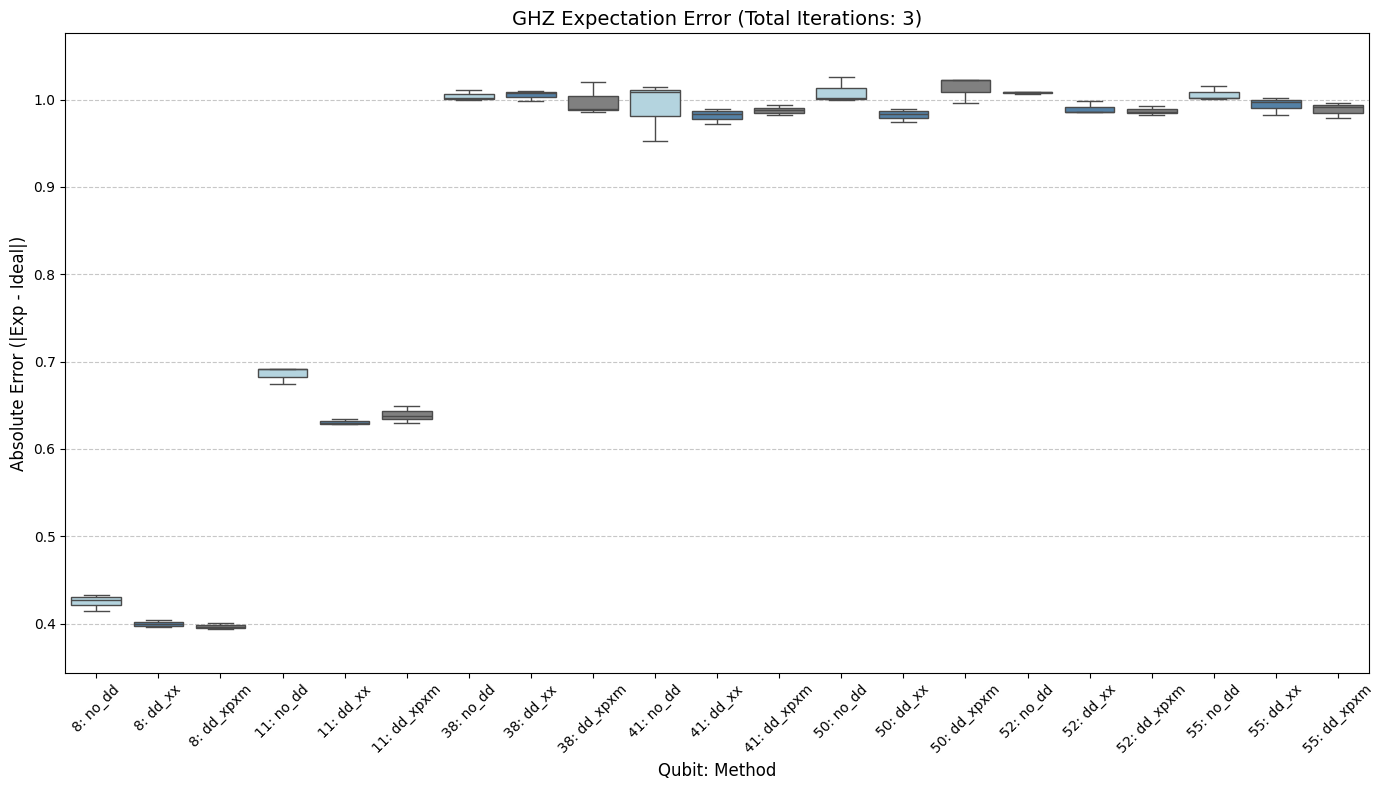

In [29]:
plt.figure(figsize=(14, 8))

# Define colors (Light Blue, Steel Blue, Grey)
color_map = {"no_dd": "#ADD8E6", "dd_xx": "#4682B4", "dd_xpxm": "#808080"}
unique_labels = df["Label"].unique()
palette_list = [color_map[label.split(": ")[1]] for label in unique_labels]

sns.boxplot(
    data=df,
    x="Label",
    y="Abs_Error",  # Plotting Error
    hue="Label",
    palette=palette_list,
    dodge=False,
    legend=False,
)

plt.title(f"GHZ Expectation Error (Total Iterations: {len(batch_jobs)})", fontsize=14)
plt.xlabel("Qubit: Method", fontsize=12)
plt.ylabel("Absolute Error (|Exp - Ideal|)", fontsize=12)

# Calculate minimum fidelity from your data and subtract a 0.05 buffer
min_y = df["Abs_Error"].min() - 0.05
max_y = df["Abs_Error"].max() + 0.05
plt.ylim(min_y, max_y)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [33]:
df_6 = pd.read_csv("Dd_Batch_Est_6.csv")
df_8 = pd.read_csv("Dd_Batch_Est_8.csv")
df_9 = pd.read_csv("Dd_Batch_Est_9.csv")

In [34]:
# 1. Create a list of the dataframes you want to combine
frames = [df, df_6, df_8, df_9]

# 2. Concatenate them
# ignore_index=True ensures the index resets to 0, 1, 2... continuously
df = pd.concat(frames, ignore_index=True)

# 3. (Optional but Recommended) Re-sort so the new data sits in the right place
df = df.sort_values(by=["Qubits", "Method_Index"]).reset_index(drop=True)

# Check the result
print(f"New shape: {df.shape}")
df.head()

New shape: (198, 10)


,Label,Iteration,Qubits,Abs_Error,Exp_Value,Ideal_Value,Circuit_Density,Max_Decoherence,Job_ID,Method_Index
0,7: no_dd,1,7,0.339355,-0.660645,-1.0,0.285714,0.004619,d4o4bghn1t7c73di2u4g,0
1,7: no_dd,2,7,0.345215,-0.654785,-1.0,0.285714,0.004619,d4o4bh47eg9s739a3jsg,0
2,7: no_dd,3,7,0.345215,-0.654785,-1.0,0.285714,0.004619,d4o4bhch0bas73fc5aog,0
3,7: dd_xx,1,7,0.370605,-0.629395,-1.0,0.285714,0.004619,d4o4bghn1t7c73di2u4g,1
4,7: dd_xx,2,7,0.375977,-0.624023,-1.0,0.285714,0.004619,d4o4bh47eg9s739a3jsg,1


In [35]:
# Keep rows where Method_Index is NOT 2
df = df[df["Method_Index"] != 2]

# Reset index to fix gaps (e.g., going from row 1 to row 3)
df = df.reset_index(drop=True)

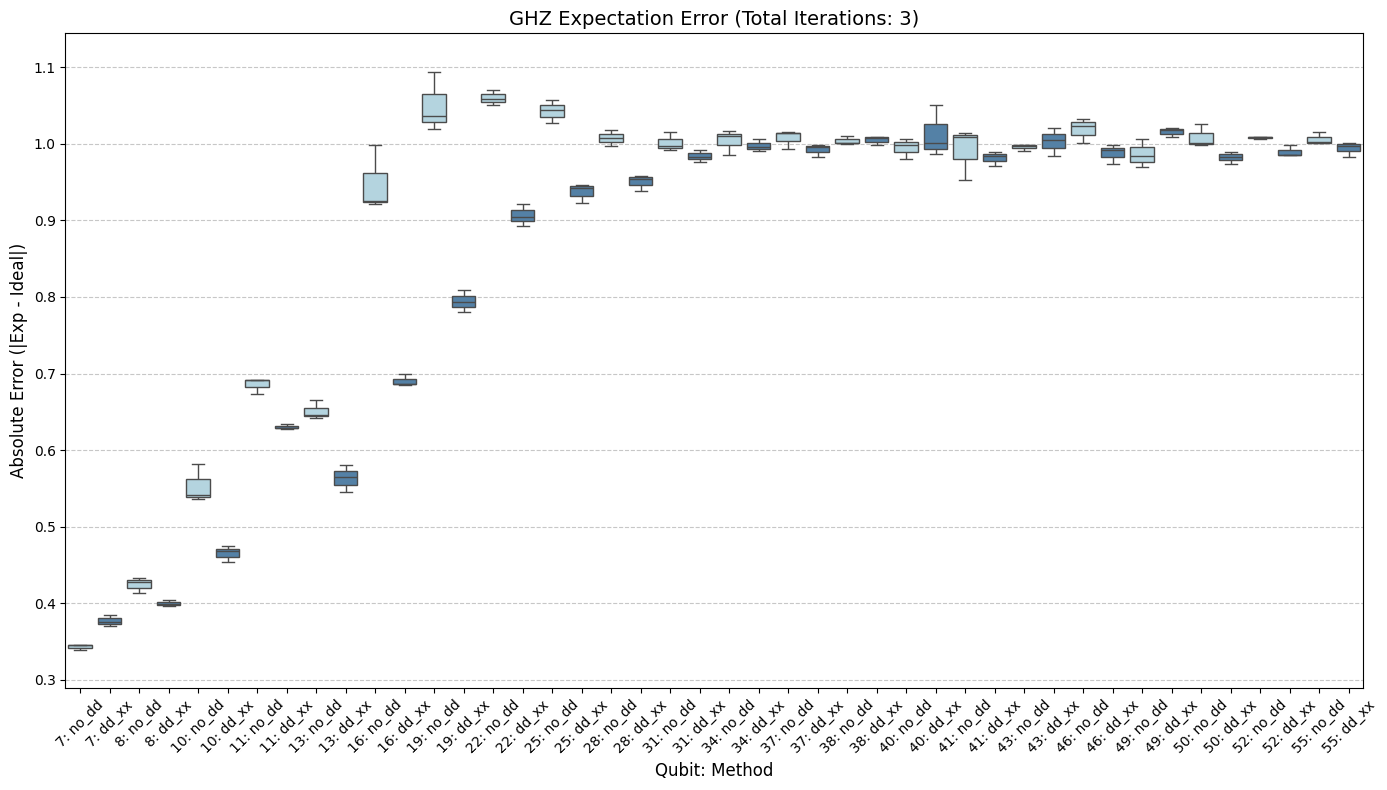

In [36]:
plt.figure(figsize=(14, 8))

# Define colors (Light Blue, Steel Blue, Grey)
color_map = {"no_dd": "#ADD8E6", "dd_xx": "#4682B4" }
unique_labels = df["Label"].unique()
palette_list = [color_map[label.split(": ")[1]] for label in unique_labels]

sns.boxplot(
    data=df,
    x="Label",
    y="Abs_Error",  # Plotting Error
    hue="Label",
    palette=palette_list,
    dodge=False,
    legend=False,
)

plt.title(f"GHZ Expectation Error (Total Iterations: {len(batch_jobs)})", fontsize=14)
plt.xlabel("Qubit: Method", fontsize=12)
plt.ylabel("Absolute Error (|Exp - Ideal|)", fontsize=12)

# Calculate minimum fidelity from your data and subtract a 0.05 buffer
min_y = df["Abs_Error"].min() - 0.05
max_y = df["Abs_Error"].max() + 0.05
plt.ylim(min_y, max_y)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [37]:
# 1. Aggregate: Calculate mean Abs_Error for each Qubit & Method
# We also grab the metrics (Density/Decoherence) which are constant per Qubit
agg_df = (
    df.groupby(["Qubits", "Method_Index"])
    .agg({"Abs_Error": "mean", "Circuit_Density": "first", "Max_Decoherence": "first"})
    .reset_index()
)

# 2. Pivot to get columns: [Qubits, Error_no_dd, Error_dd_xx, Density, Decoherence]
# Filter only for no_dd (0) and dd_xx (1)
pivot_df = (
    agg_df[agg_df["Method_Index"].isin([0, 1])]
    .pivot(
        index=["Qubits", "Circuit_Density", "Max_Decoherence"],
        columns="Method_Index",
        values="Abs_Error",
    )
    .reset_index()
)

# Rename columns for clarity (0 -> no_dd, 1 -> dd_xx)
pivot_df = pivot_df.rename(columns={0: "Error_no_dd", 1: "Error_dd_xx"})

# 3. Calculate Improvement
# Improvement = Error(no_dd) - Error(dd_xx)
# Positive value means dd_xx reduced the error (Better)
pivot_df["Improvement"] = pivot_df["Error_no_dd"] - pivot_df["Error_dd_xx"]

print(pivot_df.head())

Method_Index  Qubits  Circuit_Density  Max_Decoherence  Error_no_dd  \
0                  7         0.285714         0.004619     0.343262   
1                  8         0.252604         0.027991     0.424642   
2                 10         0.205000         0.027991     0.553060   
3                 11         0.187328         0.028355     0.685710   
4                 13         0.159763         0.098807     0.651042   

Method_Index  Error_dd_xx  Improvement  
0                0.377116    -0.033854  
1                0.399577     0.025065  
2                0.465658     0.087402  
3                0.630697     0.055013  
4                0.563802     0.087240  


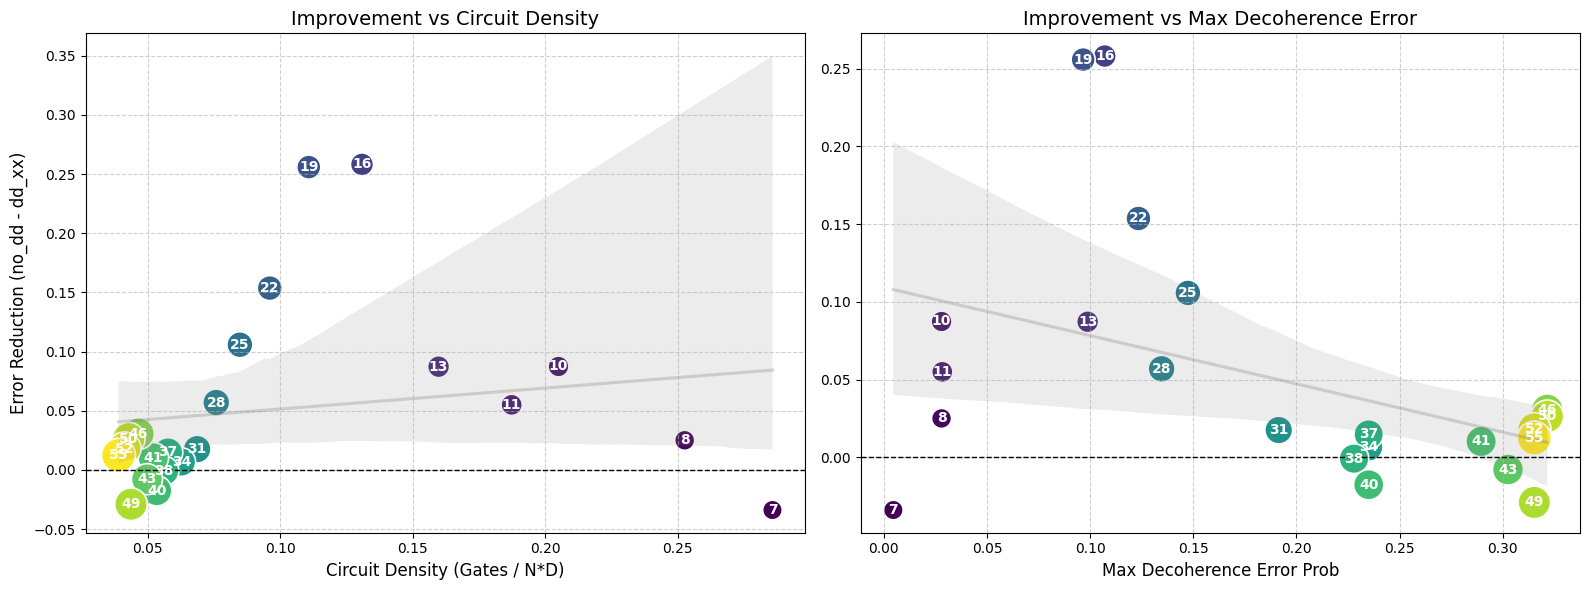

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- PLOT 1: Improvement vs Circuit Density ---
sns.scatterplot(
    data=pivot_df,
    x="Circuit_Density",
    y="Improvement",
    size="Qubits",
    sizes=(200, 600),  # Increased size slightly to make room for text
    hue="Qubits",
    palette="viridis",
    ax=axes[0],
    legend=False,  # Turning off legend since we are labeling the dots directly
)

# Add Trendline
sns.regplot(
    data=pivot_df,
    x="Circuit_Density",
    y="Improvement",
    scatter=False,
    ax=axes[0],
    color="gray",
    line_kws={"alpha": 0.3},
)

# --- ADD LABELS (The new part) ---
# Loop through the dataframe and place text at x,y coordinates
for i in range(pivot_df.shape[0]):
    row = pivot_df.iloc[i]
    axes[0].text(
        x=row["Circuit_Density"],
        y=row["Improvement"],
        s=f"{int(row['Qubits'])}",  # The text label
        horizontalalignment="center",
        verticalalignment="center",
        size=10,
        color="white",  # White text usually pops on dark/viridis bubbles
        weight="bold",
    )

axes[0].set_title("Improvement vs Circuit Density", fontsize=14)
axes[0].set_xlabel("Circuit Density (Gates / N*D)", fontsize=12)
axes[0].set_ylabel("Error Reduction (no_dd - dd_xx)", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.6)
# Force a horizontal line at 0 to clearly see negative vs positive
axes[0].axhline(0, color="black", linewidth=1, linestyle="--")


# --- PLOT 2: Improvement vs Max Decoherence ---
sns.scatterplot(
    data=pivot_df,
    x="Max_Decoherence",
    y="Improvement",
    size="Qubits",
    sizes=(200, 600),
    hue="Qubits",
    palette="viridis",
    ax=axes[1],
    legend=False,
)

sns.regplot(
    data=pivot_df,
    x="Max_Decoherence",
    y="Improvement",
    scatter=False,
    ax=axes[1],
    color="gray",
    line_kws={"alpha": 0.3},
)

# --- ADD LABELS FOR PLOT 2 ---
for i in range(pivot_df.shape[0]):
    row = pivot_df.iloc[i]
    axes[1].text(
        x=row["Max_Decoherence"],
        y=row["Improvement"],
        s=f"{int(row['Qubits'])}",
        horizontalalignment="center",
        verticalalignment="center",
        size=10,
        color="white",
        weight="bold",
    )

axes[1].set_title("Improvement vs Max Decoherence Error", fontsize=14)
axes[1].set_xlabel("Max Decoherence Error Prob", fontsize=12)
axes[1].set_ylabel("")
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].axhline(0, color="black", linewidth=1, linestyle="--")

plt.tight_layout()
plt.show()